<a href="https://colab.research.google.com/github/kshitiz-glitch/Detection-of-Acute-leukemia/blob/main/finalmini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"pro40504","key":"07a5b0a690622b0da4f5bd6c3b6e8ef8"}'}

In [ ]:
import os

# First, rename the uploaded file to 'kaggle.json'
os.rename('kaggle (1).json', 'kaggle.json')

# Now create the directory and move kaggle.json there
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d mehradaria/leukemia

Dataset URL: https://www.kaggle.com/datasets/mehradaria/leukemia
License(s): ODbL-1.0


In [ ]:
!unzip leukemia.zip -d leukemia_dataset


Streaming output truncated to the last 5000 lines.
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-024.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-025.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-026.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-027.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-028.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-029.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-030.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-031.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-032.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-033.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-034.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-035.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-036.jpg  
  inflating: leukemia_data

In [ ]:
!unzip leukemia.zip -d leukemia_dataset


Streaming output truncated to the last 5000 lines.
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-024.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-025.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-026.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-027.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-028.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-029.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-030.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-031.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-032.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-033.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-034.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-035.jpg  
  inflating: leukemia_dataset/Original/Pre/WBC-Malignant-Pre-036.jpg  
  inflating: leukemia_data

In [ ]:
import os, shutil, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
torch.backends.cudnn.benchmark = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
original_dataset_dir = 'leukemia_dataset/Original'  # <-- POINT HERE at your real classes
split_base_dir     = 'leukemia_dataset_split'


In [ ]:
shutil.rmtree(split_base_dir, ignore_errors=True)


In [ ]:
for split in ('train','val'):
    os.makedirs(os.path.join(split_base_dir, split), exist_ok=True)

In [ ]:
for cls in os.listdir(original_dataset_dir):
    cls_path = os.path.join(original_dataset_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    imgs = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
    random.shuffle(imgs)
    cut = int(0.8 * len(imgs))

    for split, subset in [('train', imgs[:cut]), ('val', imgs[cut:])]:
        dst_dir = os.path.join(split_base_dir, split, cls)
        os.makedirs(dst_dir, exist_ok=True)
        for img in subset:
            shutil.copy(
                os.path.join(cls_path, img),
                os.path.join(dst_dir, img)
            )

print("✅ Split done at:", split_base_dir)

✅ Split done at: leukemia_dataset_split


In [ ]:
dataset_dir = split_base_dir

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(
    root=os.path.join(dataset_dir, 'train'),
    transform=train_transform
)
val_dataset   = datasets.ImageFolder(
    root=os.path.join(dataset_dir, 'val'),
    transform=val_transform
)

train_loader = DataLoader(
    train_dataset, batch_size=32,
    shuffle=True,  num_workers=8, pin_memory=True
)
val_loader   = DataLoader(
    val_dataset,   batch_size=32,
    shuffle=False, num_workers=8, pin_memory=True
)

print("Classes:", train_dataset.classes)

Classes: ['Benign', 'Early', 'Pre', 'Pro']


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
model = models.resnet50(pretrained=True)
for param in model.parameters():   # freeze backbone
    param.requires_grad = False

# Replace the classifier head
num_ftrs      = model.fc.in_features
model.fc      = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, len(train_dataset.classes))
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=5e-4)

# Mixed-precision scaler
scaler = torch.cuda.amp.GradScaler()

<ipython-input-32-b4f3cb904455>:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
num_epochs = 15
train_losses, val_losses, val_accs = [], [], []

for epoch in range(num_epochs):
    # — Training ─────────────────────────────────────────
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # — Validation ───────────────────────────────────────
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ")
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_bar.set_postfix(val_loss=val_loss/total, val_acc=correct/total)

    avg_val_loss = val_loss / len(val_loader)
    val_acc      = correct  / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(f"→ Epoch {epoch+1} summary: "
          f"Train Loss {avg_train_loss:.4f}, "
          f"Val Loss {avg_val_loss:.4f}, "
          f"Val Acc {val_acc:.4f}")

Epoch 1/15 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]<ipython-input-34-6c169b3039a8>:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/15 [Val]  :   0%|          | 0/21 [00:00<?, ?it/s]<ipython-input-34-6c169b3039a8>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/15 [Val]  : 100%|██████████| 21/21 [02:49<00:00,  8.06s/it, val_acc=0.791, val_loss=0.0151]


→ Epoch 1 summary: Train Loss 0.6297, Val Loss 0.4690, Val Acc 0.7914


Epoch 2/15 [Val]  : 100%|██████████| 21/21 [02:47<00:00,  8.00s/it, val_acc=0.928, val_loss=0.00682]


→ Epoch 2 summary: Train Loss 0.3649, Val Loss 0.2118, Val Acc 0.9279


Epoch 3/15 [Val]  : 100%|██████████| 21/21 [02:48<00:00,  8.01s/it, val_acc=0.945, val_loss=0.00451]


→ Epoch 3 summary: Train Loss 0.3049, Val Loss 0.1401, Val Acc 0.9448


Epoch 4/15 [Val]  : 100%|██████████| 21/21 [02:49<00:00,  8.07s/it, val_acc=0.948, val_loss=0.00461]


→ Epoch 4 summary: Train Loss 0.2566, Val Loss 0.1430, Val Acc 0.9479


Epoch 5/15 [Val]  : 100%|██████████| 21/21 [02:51<00:00,  8.16s/it, val_acc=0.956, val_loss=0.00447]


→ Epoch 5 summary: Train Loss 0.2419, Val Loss 0.1387, Val Acc 0.9555


Epoch 6/15 [Val]  : 100%|██████████| 21/21 [02:51<00:00,  8.15s/it, val_acc=0.956, val_loss=0.00375]


→ Epoch 6 summary: Train Loss 0.2158, Val Loss 0.1163, Val Acc 0.9555


Epoch 7/15 [Val]  : 100%|██████████| 21/21 [02:49<00:00,  8.08s/it, val_acc=0.937, val_loss=0.0051]


→ Epoch 7 summary: Train Loss 0.2047, Val Loss 0.1583, Val Acc 0.9371


Epoch 8/15 [Val]  : 100%|██████████| 21/21 [02:49<00:00,  8.07s/it, val_acc=0.954, val_loss=0.0037]


→ Epoch 8 summary: Train Loss 0.2133, Val Loss 0.1148, Val Acc 0.9540


Epoch 9/15 [Val]  : 100%|██████████| 21/21 [02:49<00:00,  8.08s/it, val_acc=0.963, val_loss=0.0032]


→ Epoch 9 summary: Train Loss 0.2223, Val Loss 0.0992, Val Acc 0.9632


Epoch 10/15 [Val]  : 100%|██████████| 21/21 [02:50<00:00,  8.10s/it, val_acc=0.96, val_loss=0.00376]


→ Epoch 10 summary: Train Loss 0.2024, Val Loss 0.1168, Val Acc 0.9601


Epoch 11/15 [Val]  : 100%|██████████| 21/21 [02:49<00:00,  8.07s/it, val_acc=0.956, val_loss=0.00376]


→ Epoch 11 summary: Train Loss 0.1907, Val Loss 0.1168, Val Acc 0.9555


Epoch 12/15 [Val]  : 100%|██████████| 21/21 [02:49<00:00,  8.05s/it, val_acc=0.957, val_loss=0.00442]


→ Epoch 12 summary: Train Loss 0.1910, Val Loss 0.1371, Val Acc 0.9571


Epoch 13/15 [Val]  : 100%|██████████| 21/21 [02:49<00:00,  8.06s/it, val_acc=0.951, val_loss=0.0042]


→ Epoch 13 summary: Train Loss 0.2069, Val Loss 0.1305, Val Acc 0.9509


Epoch 14/15 [Val]  : 100%|██████████| 21/21 [02:48<00:00,  8.02s/it, val_acc=0.974, val_loss=0.00291]


→ Epoch 14 summary: Train Loss 0.1852, Val Loss 0.0902, Val Acc 0.9739


Epoch 15/15 [Val]  : 100%|██████████| 21/21 [02:50<00:00,  8.12s/it, val_acc=0.966, val_loss=0.00288]

→ Epoch 15 summary: Train Loss 0.1977, Val Loss 0.0895, Val Acc 0.9663


In [ ]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

overall_acc = correct / total
print(f"Overall Validation Accuracy: {overall_acc:.4f}")

Overall Validation Accuracy: 0.9663


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


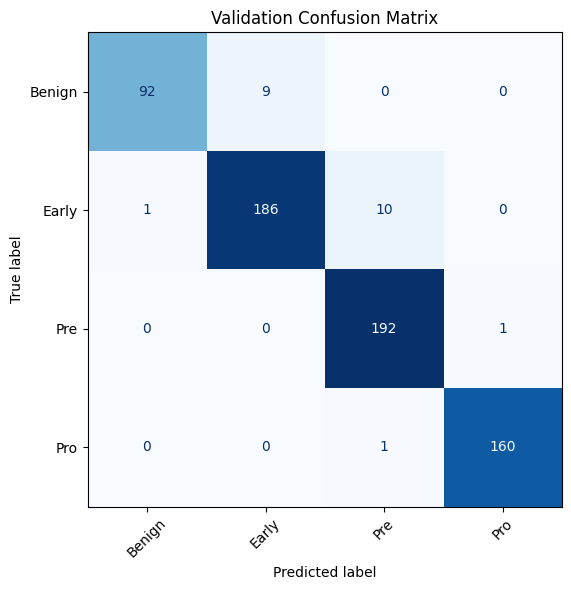

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) Gather all predictions and true labels
all_preds = []
all_labels = []
model.eval()

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 2) Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=train_dataset.classes)

# 3) Plot
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title("Validation Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

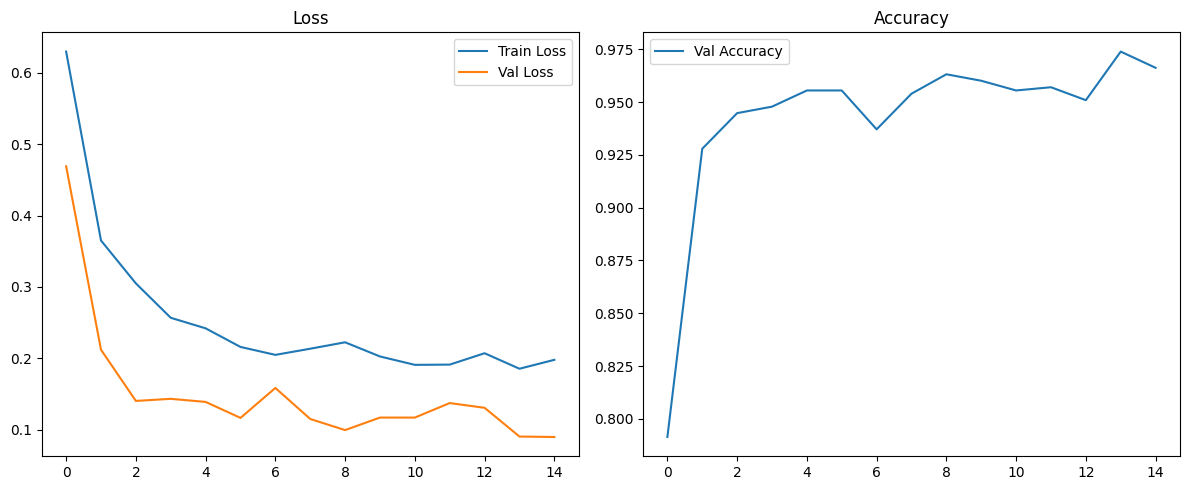

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

train_acc = correct / total
print(f"Training Accuracy: {train_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training Accuracy: 0.9543
